In [58]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures
using HDF5

In [59]:
N = 101 #Number of lattice sites per dimension
d = 1 #Number of spatial dimensions
dx = 1 #Lattice spacing

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (12.5)/(N*dx) #Discrete change in momentum

Delta = 0
mass = 2.3
p_i = [-(n_0*dp)+(s-Delta)*dp for s in 0:N-1]
om_i = [sqrt(((2/dx)*sin(p_i[i]*(dx/2)))^2 + mass^2) for i in 1:N]

101-element Vector{Float64}:
 2.3019623876168467
 2.310345275081877
 2.325129091591098
 2.3459694153815147
 2.3723928277194806
 2.40381857801318
 2.439582847988669
 2.4789634969195213
 2.5212035464380707
 2.5655321906289603
 2.6111826614677
 2.6574067465631845
 2.703486099131218
 ⋮
 2.6574067465631845
 2.6111826614677
 2.5655321906289603
 2.5212035464380707
 2.478963496919522
 2.439582847988669
 2.40381857801318
 2.3723928277194806
 2.3459694153815147
 2.325129091591098
 2.310345275081877
 2.3019623876168467

In [60]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

101-element Vector{Index{Int64}}:
 (dim=9|id=459|"Boson,Site,n=1")
 (dim=9|id=397|"Boson,Site,n=2")
 (dim=9|id=203|"Boson,Site,n=3")
 (dim=9|id=721|"Boson,Site,n=4")
 (dim=9|id=73|"Boson,Site,n=5")
 (dim=9|id=582|"Boson,Site,n=6")
 (dim=9|id=652|"Boson,Site,n=7")
 (dim=9|id=39|"Boson,Site,n=8")
 (dim=9|id=408|"Boson,Site,n=9")
 (dim=9|id=460|"Boson,Site,n=10")
 (dim=9|id=950|"Boson,Site,n=11")
 (dim=9|id=652|"Boson,Site,n=12")
 (dim=9|id=276|"Boson,Site,n=13")
 ⋮
 (dim=9|id=947|"Boson,Site,n=90")
 (dim=9|id=541|"Boson,Site,n=91")
 (dim=9|id=336|"Boson,Site,n=92")
 (dim=9|id=772|"Boson,Site,n=93")
 (dim=9|id=223|"Boson,Site,n=94")
 (dim=9|id=492|"Boson,Site,n=95")
 (dim=9|id=105|"Boson,Site,n=96")
 (dim=9|id=712|"Boson,Site,n=97")
 (dim=9|id=312|"Boson,Site,n=98")
 (dim=9|id=263|"Boson,Site,n=99")
 (dim=9|id=523|"Boson,Site,n=100")
 (dim=9|id=163|"Boson,Site,n=101")

In [61]:
function MakeState(excitation_dict)
    for i in keys(excitation_dict)
        if i > N
            error("excitation_dict contains an index that is greater than the number of sites in the lattice.")
        end
    end

    state = []
    for i in 1:N
        if haskey(excitation_dict, i)
            push!(state, excitation_dict[i])
        else
            push!(state, "0")
        end
    end

    return state
end

MakeState (generic function with 1 method)

In [62]:
gs_Dict = Dict() #Dictionary containing excitations (or lack thereof) in the ground state
psi_gs = MPS(sites, MakeState(gs_Dict)) #Ground State

MPS
[1] ((dim=9|id=459|"Boson,Site,n=1"), (dim=1|id=750|"Link,l=1"))
[2] ((dim=1|id=750|"Link,l=1"), (dim=9|id=397|"Boson,Site,n=2"), (dim=1|id=576|"Link,l=2"))
[3] ((dim=1|id=576|"Link,l=2"), (dim=9|id=203|"Boson,Site,n=3"), (dim=1|id=497|"Link,l=3"))
[4] ((dim=1|id=497|"Link,l=3"), (dim=9|id=721|"Boson,Site,n=4"), (dim=1|id=53|"Link,l=4"))
[5] ((dim=1|id=53|"Link,l=4"), (dim=9|id=73|"Boson,Site,n=5"), (dim=1|id=503|"Link,l=5"))
[6] ((dim=1|id=503|"Link,l=5"), (dim=9|id=582|"Boson,Site,n=6"), (dim=1|id=471|"Link,l=6"))
[7] ((dim=1|id=471|"Link,l=6"), (dim=9|id=652|"Boson,Site,n=7"), (dim=1|id=894|"Link,l=7"))
[8] ((dim=1|id=894|"Link,l=7"), (dim=9|id=39|"Boson,Site,n=8"), (dim=1|id=354|"Link,l=8"))
[9] ((dim=1|id=354|"Link,l=8"), (dim=9|id=408|"Boson,Site,n=9"), (dim=1|id=755|"Link,l=9"))
[10] ((dim=1|id=755|"Link,l=9"), (dim=9|id=460|"Boson,Site,n=10"), (dim=1|id=863|"Link,l=10"))
[11] ((dim=1|id=863|"Link,l=10"), (dim=9|id=950|"Boson,Site,n=11"), (dim=1|id=447|"Link,l=11"))
[12] ((d

In [63]:
function phi_n(m::Real) #Field value in the lightlike direction, i.e. phi_x_{n_0+m}
    phi_lightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a", (i) #n*m*dx = (1,1)*m*dx = (m*dx,m*dx)
        phi_lightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx - om_i[i]*m*dx)), "a†", (i)
    end
    return phi_lightlike
end

function phi_nbar(m::Real) #Field value in the anti-lightlike direction, i.e. phi_x_{n_0-m}
    phi_antilightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a", (i) #nbar*m*dx = (1,-1)*m*dx = (m*dx,-m*dx)
        phi_antilightlike += (1/sqrt(N))*(1/sqrt(2*om_i[i]))*exp(-im*(p_i[i]*m*dx + om_i[i]*m*dx)), "a†", (i)
    end
    return phi_antilightlike
end

phi_nbar (generic function with 1 method)

In [64]:
function Y_n(g::Real)
    Y_n_op = OpSum()
    for m in 0:n_0
        Y_n_op += im*g*dx*phi_n(m)
    end
    return Y_n_op
end

function Y_nbar_dag(g::Real)
    Y_nbar_dag_op = OpSum()
    for m in 0:n_0
        Y_nbar_dag_op += -im*g*dx*phi_nbar(m)
    end
    return Y_nbar_dag_op
end

function YnbdYn(g::Real)
    return MPO(Y_nbar_dag(g)+Y_n(g), sites)
end

YnbdYn (generic function with 1 method)

In [65]:
t_range = range(0, stop=20, length=201)
g_list = [0.5, 1]
if N > 14 #If N > 14, increase the threshold for ITensor's contraction warning
    ITensors.set_warn_order(N)
    ITensors.set_warn_order(N)
else #Else, reset the warning threshold to the default number of contractions, 14
    ITensors.set_warn_order(14)
    ITensors.set_warn_order(14)
end

101

In [66]:
SF_data = h5open("Soft_Function_data.h5", "r") #Open the Soft Function data HDF5 file in read/write mode
if haskey(SF_data, "N=$N, m=$mass, dp=$dp") == false #Check if the "N=$N, m=$mass, dp=$dp" group doesn't exist
    create_group(SF_data, "N=$N, m=$mass, dp=$dp") #Create a group within the HDF5 file corresponding to the initial parameters
end
SF_data_group = SF_data["N=$N, m=$mass, dp=$dp"]

📂 HDF5.Group: /N=101, m=2.3, dp=0.12376237623762376 (file: Soft_Function_data.h5)
├─ 📂 g=0.5
│  ├─ 📂 Psi_0, t=0.0
│  │  ├─ 🏷️ type
│  │  ├─ 🏷️ version
│  │  ├─ 📂 MPS[100]
│  │  │  ├─ 🏷️ type
│  │  │  ├─ 🏷️ version
│  │  │  ├─ 📂 inds
│  │  │  │  ├─ 🏷️ type
│  │  │  │  ├─ 🏷️ version
│  │  │  │  ├─ 📂 index_1
│  │  │  │  │  └─ (8 children)
│  │  │  │  ├─ 📂 index_2
│  │  │  │  │  └─ (8 children)
│  │  │  │  ├─ 📂 index_3
│  │  │  │  │  └─ (8 children)
│  │  │  │  └─ 🔢 length
│  │  │  └─ 📂 storage
│  │  │     ├─ 🏷️ type
│  │  │     ├─ 🏷️ version
│  │  │     └─ 🔢 data
│  │  ├─ 📂 MPS[101]
│  │  │  ├─ 🏷️ type
│  │  │  ├─ 🏷️ version
│  │  │  ├─ 📂 inds
│  │  │  │  ├─ 🏷️ type
│  │  │  │  ├─ 🏷️ version
│  │  │  │  ├─ 📂 index_1
│  │  │  │  │  └─ (8 children)
│  │  │  │  ├─ 📂 index_2
│  │  │  │  │  └─ (8 children)
│  │  │  │  └─ 🔢 length
│  │  │  └─ 📂 storage
│  │  │     ├─ 🏷️ type
│  │  │     ├─ 🏷️ version
│  │  │     └─ 🔢 data
│  │  ├─ 📂 MPS[10]
│  │  │  ├─ 🏷️ type
│  │  │  ├─ 🏷️ version
│  │  │  ├─

### Calculating S(t)

In [67]:
#Create the states |Psi_0> = Y_nbar^dag(0)Y_n(0)|Ω> and |Psi_t> = e^{iHt}Y_nbar^dag(0)Y_n(0)e^{-iHt}|Ω> for some value of g and t
function MakeStates(g, t)
    Psi_0 = tdvp(YnbdYn(g), 1, psi_gs; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #tdvp calculates exp(op*t)|psi>. By setting t=1, tdvp reduces to exp(op)|psi>
    
    psi_t = tdvp(MPO(-im*H, sites), t, psi_gs; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #Time evolve the ground state
    psi_t = tdvp(YnbdYn(g), 1, psi_t; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #Apply the Wilson line operator
    Psi_t = tdvp(MPO(im*H, sites), t, psi_t; nsteps=1, maxdim=500, cutoff=1e-15, normalize=true) #Time evolve back

    return Psi_0, Psi_t
end

MakeStates (generic function with 1 method)

In [68]:
for g in g_list
    S_t_list = ComplexF64[] #Create temporary lists for storing S(t), the Psi_0 MPS, and the Psi_t MPS for a given value of g
    if haskey(SF_data_group, "g=$g") == false #Check if the "g=$g" subgroup doesn't exist
        create_group(SF_data_group, "g=$g") #Create a subgroup within the "N=$N, m=$mass, dp=$dp" group corresponding to the given value of g
        for t in t_range
            #Calculate S(t) by taking the inner product between |Psi_0> and |Psi_t>
            Psi_0, Psi_t = MakeStates(g, t)
            
            if haskey(SF_data_group["g=$g"], "Psi_0, t=$t") == false
                SF_data_group["g=$g"]["Psi_0, t=$t"] = Psi_0 #Create a dataset containing the Psi_0 MPS at timestep t for a given value of g
            end
            if haskey(SF_data_group["g=$g"], "Psi_t, t=$t") == false
                SF_data_group["g=$g"]["Psi_t, t=$t"] = Psi_t #Create a dataset containing the Psi_t MPS at timestep t for a given value of g
            end
            
            S_t = inner(Psi_t, Psi_0)
            push!(S_t_list, S_t) #Store the S(t) value at timestep t
        end
        if haskey(SF_data_group["g=$g"], "S(t)") == false
            SF_data_group["g=$g"]["S(t)"] = S_t_list #Create a dataset containing the list of S(t) values at each timestep t for a given value of g
        end
    end
end

#Store the list of S(t) values into a dictionary 'keyed' by the corresponding value of g
S_t_list_g = Dict("g=$g" => [SF_data_group["g=$g"]["S(t)"][i] for i in 1:length(t_range)] for g in g_list)

Dict{String, Vector{ComplexF64}} with 2 entries:
  "g=1.0" => [1.0+2.89645e-16im, 0.995567-0.0911432im, 0.982318-0.181378im, 0.9…
  "g=0.5" => [1.0-1.49806e-16im, 0.999664-0.0231017im, 0.998656-0.0461806im, 0.…

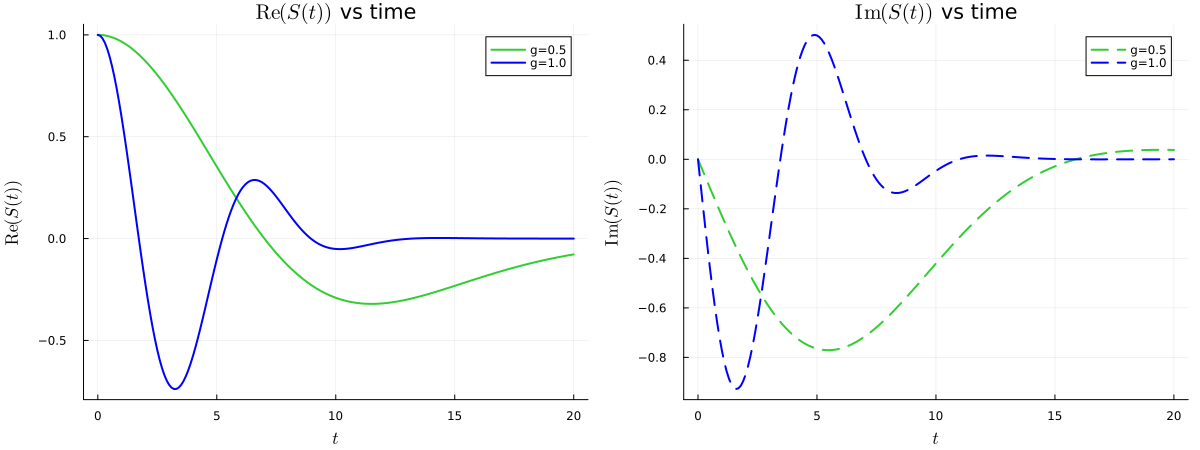

In [69]:
colors = ["lime green", "blue"]
Re_plt = plot()
for (i, g) in enumerate(g_list)
    Re_plt = plot!(
        t_range,
        real(S_t_list_g["g=$g"]);
        label = "g=$g",
        lw = 2,
        color = colors[i]
    )
end

Im_plt = plot()
for (i, g) in enumerate(g_list)
    Im_plt = plot!(
        t_range,
        imag(S_t_list_g["g=$g"]);
        label = "g=$g",
        lw = 2,
        ls = :dash,
        color = colors[i]
    )
end

plot(Re_plt, Im_plt, layout=(1,2), title=["\$\\mathrm{Re}(S(t))\$ vs time" "\$\\mathrm{Im}(S(t))\$ vs time"],
    guidefont=font(12),
    xlabel=["\$t\$" "\$t\$"],
    ylabel=["\$\\mathrm{Re}(S(t))\$" "\$\\mathrm{Im}(S(t))\$"],
    size=(1200, 450), 
    bottom_margin=18px,
    left_margin=22px)
#savefig("S(t) Plots/S(t), N=$N, m=23e-1, dp=417e-2")

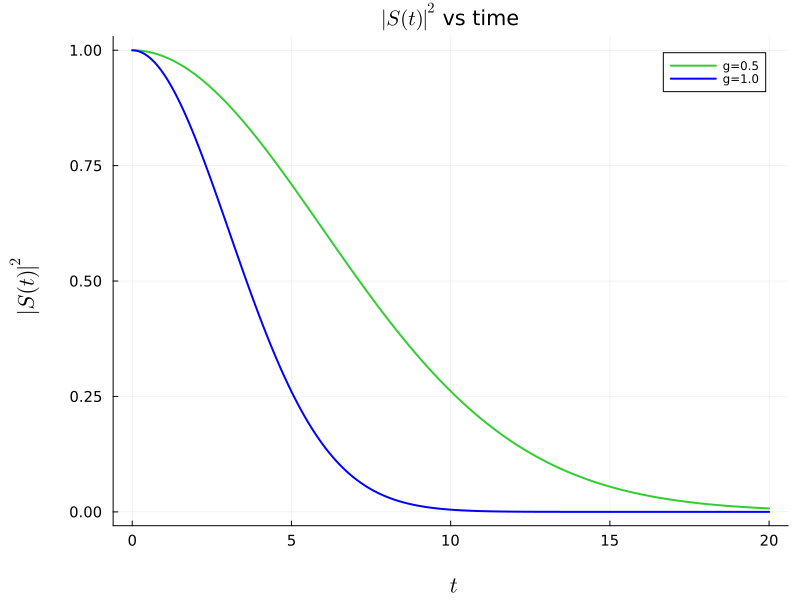

In [70]:
gr()         
default(size=(800, 600))    
plot()
for (i, g) in enumerate(g_list)
    plot!(
        t_range,
        real(S_t_list_g["g=$g"]).^2 .+ imag(S_t_list_g["g=$g"]).^2;
        label = "g=$g",
        lw = 2,
        color = colors[i]
    )
end

xlabel!("\n \$t\$", guidefont=font(15))
ylabel!("\$|S(t)|^2\$ \n", guidefont=font(15))
plot!(tickfontsize=10)
plot!(left_margin = 18px)
title!("\$|S(t)|^2\$ vs time")

#savefig("S(t) Plots/abs(S(t)), N=$N, m=23e-1, dp=417e-2")

### Calculating S(E)

In [71]:
function S(E::Real, S_t)
    dt = (2/dx)/(length(t_range)-1)
    FTSoftFunc = 0
    for t in 1:(length(t_range)-1)
        f1 = exp(im*E*t_range[t])*S_t[t]
        f2 = exp(im*E*t_range[t+1])*S_t[t+1]
        FTSoftFunc += (dt/2)*(f1+f2)
    end
    return FTSoftFunc
end

S (generic function with 1 method)

In [72]:
E_range = 0:0.05:15
for (i, g) in enumerate(g_list)
    S_E_list = ComplexF64[] #Create a temporary list for containing S(E) values for a given value of g
    S_E_list = [S(E, S_t_list_g["g=$g"]) for E in E_range] #Store S(E) for each value of E
    if haskey(SF_data_group["g=$g"], "S(E)") == false
        SF_data_group["g=$g"]["S(E)"] = S_E_list #Create a dataset containing the list of S(E) values at each energy E for a given value of g
    end
end

#Store the list of S(E) values into a dictionary 'keyed' by the corresponding value of g
S_E_list_g = Dict("g=$g" => [SF_data_group["g=$g"]["S(E)"][i] for i in 1:length(E_range)] for g in g_list)

Dict{String, Vector{ComplexF64}} with 2 entries:
  "g=1.0" => [9.07099e-6-0.117853im, 3.05417e-5-0.126097im, 0.000136125-0.13582…
  "g=0.5" => [0.141869-0.64748im, 0.392558-0.723322im, 0.691988-0.656977im, 0.9…

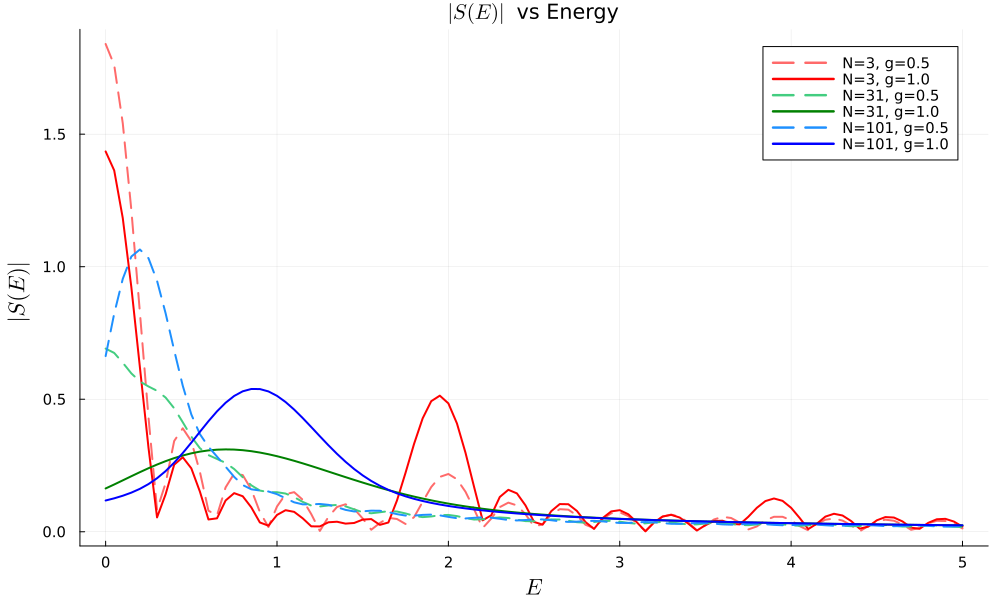

In [73]:
gr()
plot()
#= for (i, g) in enumerate(g_list)
    plot!(
        E_range,
        [abs(S_E_list_g["g=$g"][k]) for k in 1:length(E_range)];
        label = "g=$g",
        lw = 2,
        color = colors[i]
    )
end =#

N_list = [3, 31, 101]
group_name = ["N=3, m=2.3, dp=4.166666666666667", "N=31, m=2.3, dp=0.4032258064516129", "N=101, m=2.3, dp=0.12376237623762376"]
linestyles = [:dash, :solid]
colors = [["indianred1", "red"], ["seagreen3", "green"], ["dodgerblue", "blue"]]
for (n, N) in enumerate(N_list)
    for (i, g) in enumerate(g_list)
        plot!(
            E_range[1:101],
            [abs(SF_data[group_name[n]]["g=$g"]["S(E)"][k]) for k in 1:length(E_range)][1:101];
            label = "N=$N, g=$g",
            lw = 2,
            ls = linestyles[i],
            color = colors[n][i]
        )
    end
end

close(SF_data)
xlabel!("\$E\$", guidefont=font(15))
ylabel!("\$|S(E)|\$", guidefont=font(15))
plot!(tickfontsize=10)
plot!(legendfontsize=10)
plot!(size = (1000, 600))
plot!(left_margin = 18px)
plot!(bottom_margin = 8px)
title!("\$|S(E)|\$ vs Energy")

#savefig("S(E) Plots/abs(S(E)), N=$N, m=23e-1, dp=417e-2")